In [1]:
!pip install roboflow inference supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.5/345.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 899.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.8/251.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [83]:
import os
import cv2
import matplotlib.pyplot as plt
from inference import get_model
import supervision as sv
import shutil

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="<API_KEY>")

In [81]:
CROPPED_IMAGES_FOLDER = "/content/cropped"
FAILED_DETECTION_FOLDER = "/content/failed"

In [82]:
os.makedirs(CROPPED_IMAGES_FOLDER, exist_ok=True)
os.makedirs(FAILED_DETECTION_FOLDER, exist_ok=True)

In [20]:
def resize_from_file(dir, img_filename, project):
  if not(img_filename.endswith('.jpg') or img_filename.endswith('.png')):
    return
  image_path = os.path.join(dir, img_filename)
  img = cv2.imread(image_path, cv2.IMREAD_ANYCOLOR)
  resized_img = cv2.resize(img, (128, 128))
  output_path = os.path.join(CROPPED_IMAGES_FOLDER, f"{project}_{img_filename}")
  cv2.imwrite(output_path, resized_img)

def resize_img(image, img_filename, project):
  resized_img = cv2.resize(image, (128, 128))
  output_path = os.path.join(CROPPED_IMAGES_FOLDER, f"{project}_{img_filename}")
  cv2.imwrite(output_path, resized_img)

In [23]:
def get_train_test_valid_img_dirs(project):
  TEST_DIR = os.path.join("/content", project, "test", "images")
  TRAIN_DIR = os.path.join("/content", project, "train", "images")
  VALID_DIR = os.path.join("/content", project, "valid", "images")
  return TEST_DIR, TRAIN_DIR, VALID_DIR

def get_train_test_valid_labels_dirs(project):
  TEST_DIR = os.path.join("/content", project, "test", "labels")
  TRAIN_DIR = os.path.join("/content",project, "train", "labels")
  VALID_DIR = os.path.join("/content",project, "valid", "labels")
  return TEST_DIR, TRAIN_DIR, VALID_DIR

In [51]:
def remove_file_extension(filename):
  return filename.rsplit('.')[0]

In [75]:
def get_image_names_with_class_annot(class_ids, project):
  labels_dirs = get_train_test_valid_labels_dirs(project)
  image_files = []

  for dir in labels_dirs:
    if not os.path.isdir(dir):
      continue
    for filename in os.listdir(dir):
        label_path = os.path.join(dir, filename)
        image_name = remove_file_extension(filename)
        with open(label_path, "r") as l:
          has_class = False
          lines = l.readlines()
          for line in lines:
            id = line.split()[0]
            has_class = int(id) in class_ids
        if has_class:
          image_files.append(image_name)
  return image_files

In [85]:
def copy_to_failed(image_paths):
  for image_path in image_paths:
    shutil.copy(image_path, FAILED_DETECTION_FOLDER)

### Basketball Hoop/Ball model

In [7]:
roboflow_model = get_model(model_id="basketballhoop-qogci/3", api_key="GrcU6STiS8feP1t9KFWh")

Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
Specified provider 'OpenVINOExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'


In [8]:
HOOP_CLASS_ID = 1

In [21]:
def hoop_detect_resize(dir, filename, project):
  if not(filename.endswith('.jpg') or filename.endswith('.png')):
    return

  image_path = os.path.join(dir, filename)
  image = cv2.imread(image_path, cv2.IMREAD_ANYCOLOR)
  results = roboflow_model.infer(image)

  detections = sv.Detections.from_inference(results[0].dict(by_alias=True, exclude_none=True))

  if not detections:
    print(f"No detections for {image_path}")

  for detection in detections:
      pos, _, conf, class_id, _, _ = detection
      if class_id == HOOP_CLASS_ID:
          x1, y1, x2, y2 = pos

          center_x = (x1 + x2) // 2
          center_y = (y1 + y2) // 2
          crop_size = int(max(x2 - x1, y2 - y1))

          start_x = int(max(center_x  - crop_size // 2  - 20, 0))
          start_y = int(max(center_y  - crop_size // 2  - 20, 0))
          end_x   = int(min(start_x   + crop_size       + 20, image.shape[1]))
          end_y   = int(min(start_y   + crop_size       + 20, image.shape[0]))

          cropped_image = image[start_y:end_y, start_x:end_x]
          resize_img(cropped_image, filename, project)

### 27 images

https://universe.roboflow.com/my-workspace-eehdq/basketball-goal/


In [10]:
PROJECT_NAME = "Basketball-goal-1"

In [11]:
project = rf.workspace("my-workspace-eehdq").project("basketball-goal")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


(416, 416, 3)


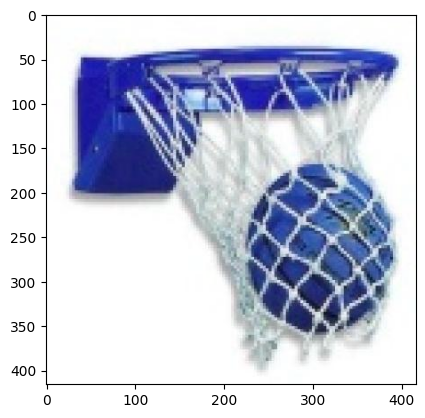

In [12]:
check_img = cv2.imread("/content/Basketball-goal-1/test/images/8L8Y57MOQ0GP_jpg.rf.dcca3f900fc9a4a1331d111d98bebc0d.jpg", cv2.IMREAD_ANYCOLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(check_img.shape)
plt.imshow(check_img)
plt.show()

In [13]:
images_dirs = get_train_test_valid_img_dirs(PROJECT_NAME)
for dir in images_dirs:
  for filename in os.listdir(dir):
      resize_from_file(dir, filename, PROJECT_NAME)

### 207 images

https://universe.roboflow.com/cjydfgfjvfg/basketball-fyp

In [14]:
project = rf.workspace("cjydfgfjvfg").project("basketball-fyp")
version = project.version(4)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [15]:
PROJECT_NAME = "Basketball-fyp-4"

In [16]:
images_dirs = get_train_test_valid_img_dirs(PROJECT_NAME)

(640, 640, 3)


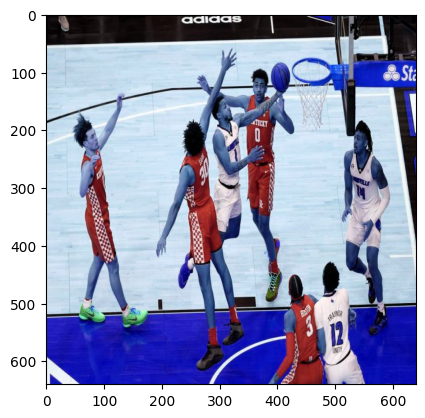

In [17]:
check_img = cv2.imread("/content/Basketball-fyp-4/train/images/1293213332-0_jpg.rf.54cc2805e29205e2ddf9a1eaffe928f5.jpg", cv2.IMREAD_ANYCOLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(check_img.shape)
plt.imshow(check_img)
plt.show()

In [22]:
images_dirs = get_train_test_valid_img_dirs(PROJECT_NAME)
for dir in images_dirs:
  for filename in os.listdir(dir):
      hoop_detect_resize(dir, filename, PROJECT_NAME)

No detections for /content/Basketball-fyp-4/test/images/New_York_Knicks_vs-_Detroit_Pistons_December_2021_24_-free_throw-1-_jpg.rf.8445374e4e324be3292e30639ed2d7c6.jpg
No detections for /content/Basketball-fyp-4/test/images/photo_2023-03-16_05-17-48-2-_jpg.rf.8be65369d3f3141876b831dd6fb78db7.jpg
No detections for /content/Basketball-fyp-4/test/images/download-1-_jpg.rf.de74e546d4fe1a392d7632ca5c75d899.jpg
No detections for /content/Basketball-fyp-4/test/images/photo_2023-03-04_21-44-50_jpg.rf.468afa5ee63d78c71604cf787a35c5b9.jpg
No detections for /content/Basketball-fyp-4/train/images/CW_Shot_mp4-108_jpg.rf.d04c552aa07009987d940a2c11ad1c63.jpg
No detections for /content/Basketball-fyp-4/train/images/photo_2023-03-04_21-44-42_jpg.rf.5a652cf86a229b38f1ba7f2ff1dcedde.jpg
No detections for /content/Basketball-fyp-4/train/images/photo_2023-03-04_21-44-59_jpg.rf.6e3f063231dc15dd01d7bc7ed197a2fc.jpg
No detections for /content/Basketball-fyp-4/train/images/CW_Shot_mp4-107_jpg.rf.757fe0f9eb47c7

### 577 imnages

https://universe.roboflow.com/fukui-univ/shootcounter-ai

In [28]:
project = rf.workspace("fukui-univ").project("shootcounter-ai")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to shootcounter-ai-1 in yolov5pytorch:: 100%|██████████| 1163/1163 [00:00<00:00, 4938.35it/s]


In [29]:
PROJECT_NAME = "shootcounter-ai-1"

(640, 640, 3)


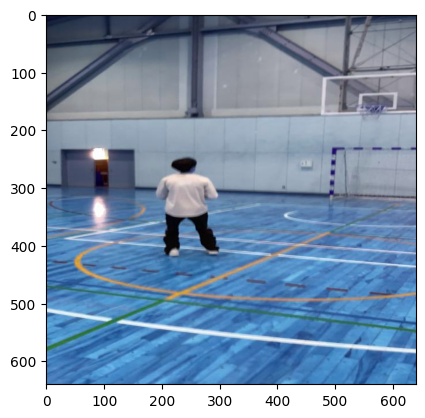

In [30]:
check_img = cv2.imread("/content/shootcounter-ai-1/train/images/IMG_7371-202-mp4-t-0-2_jpg.rf.dc9ef8364d3e23365657536e512d3a2e.jpg", cv2.IMREAD_ANYCOLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(check_img.shape)
plt.imshow(check_img)
plt.show()

In [31]:
labels_dirs = get_train_test_valid_labels_dirs(PROJECT_NAME)
unique_classes = []
for dir in labels_dirs:
  if not os.path.isdir(dir):
    continue
  for filename in os.listdir(dir):
      label_path = os.path.join(dir, filename)
      with open(label_path, "r") as l:
        lines = l.readlines()
        for line in lines:
          class_id = line.split()[0]
          unique_classes.append(class_id)
      break

print(set(unique_classes))

{'0', '1', '3', '2'}


In [64]:
images_dirs = get_train_test_valid_img_dirs(PROJECT_NAME)
for dir in images_dirs:
  if not os.path.isdir(dir):
    continue
  for filename in os.listdir(dir):
      hoop_detect_resize(dir, filename, PROJECT_NAME)

No detections for /content/shootcounter-ai-1/train/images/IMG_7506-mp4-t-0-8_jpg.rf.a839679cd98ef4937cb135dd682e2fbc.jpg
No detections for /content/shootcounter-ai-1/train/images/IMG_7371-202-mp4-t-5_jpg.rf.e5238eccee8aad15d066538b5b660e5f.jpg
No detections for /content/shootcounter-ai-1/train/images/IMG_7506-mp4-t-1-4_jpg.rf.4bc1f3ba93fedd7fe9ae4aaece508b18.jpg
No detections for /content/shootcounter-ai-1/train/images/IMG_7507-mp4-t-24-4_jpg.rf.7abd108464d7cb32997ee2e10de109a1.jpg
No detections for /content/shootcounter-ai-1/train/images/IMG_7371-202-mp4-t-14-4_jpg.rf.3bd0fc4c9cb3e21b945cb73aa58721b3.jpg
No detections for /content/shootcounter-ai-1/train/images/IMG_7506-mp4-t-2-6_jpg.rf.d3c5a6ced3adf9832657952719ae7d07.jpg
No detections for /content/shootcounter-ai-1/train/images/IMG_7371-202-mp4-t-12-2_jpg.rf.99e03fea33788c0ed2878ce6e2cb180d.jpg
No detections for /content/shootcounter-ai-1/train/images/IMG_7507-mp4-t-13-8_jpg.rf.92f301a04d38e51af1b6c4ddc2ae5054.jpg
No detections for 

### 1063 images

https://universe.roboflow.com/zaki-b86c6/basketball-jagmz

In [66]:
project = rf.workspace("zaki-b86c6").project("basketball-jagmz")
version = project.version(74)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to basketball-74 in yolov5pytorch:: 100%|██████████| 2134/2134 [00:00<00:00, 2679.84it/s]


In [68]:
PROJECT_NAME = "basketball-74"

(360, 640, 3)


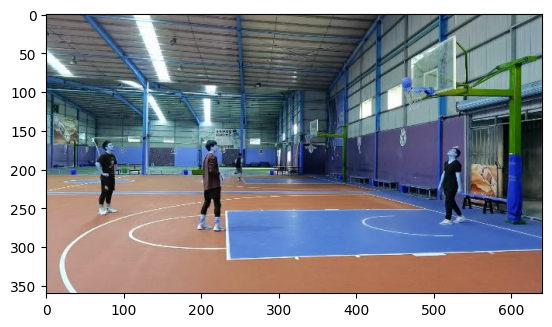

In [69]:
check_img = cv2.imread("/content/basketball-74/test/images/WX20220414-113814_png.rf.580665451628aa2cf77bcff6805a76b4.jpg", cv2.IMREAD_ANYCOLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(check_img.shape)
plt.imshow(check_img)
plt.show()

In [70]:
labels_dirs = get_train_test_valid_labels_dirs(PROJECT_NAME)
unique_classes = []
for dir in labels_dirs:
  if not os.path.isdir(dir):
    continue
  for filename in os.listdir(dir):
      label_path = os.path.join(dir, filename)
      with open(label_path, "r") as l:
        lines = l.readlines()
        for line in lines:
          class_id = line.split()[0]
          unique_classes.append(class_id)
      break

print(set(unique_classes))

{'0', '1', '2'}


In [ ]:
images_dirs = get_train_test_valid_img_dirs(PROJECT_NAME)
image_names = get_image_names_with_class_annot([2], PROJECT_NAME)

for dir in images_dirs:
  if not os.path.isdir(dir):
    continue
  for filename in os.listdir(dir):
      if not remove_file_extension(filename) in image_names:
        continue
      hoop_detect_resize(dir, filename, PROJECT_NAME)

In [86]:
failed = [
  "/content/basketball-74/test/images/im-11-30_jpg.rf.637c4e1f0347017fe1da8aeee7055d0c.jpg",
  "/content/basketball-74/test/images/im-11-31_jpg.rf.8b6cd9c627bd6a96bbc6c5234c21f36c.jpg",
  "/content/basketball-74/test/images/ima-1-28_jpg.rf.1fedc157d2a6e3a8e4312bc512b4871a.jpg",
  "/content/basketball-74/test/images/ima-4-48_jpg.rf.9b02adcdbaa143ef60b77f92674349b9.jpg",
  "/content/basketball-74/test/images/ima-4-46_jpg.rf.6657529ce63d979fae21db16ed156f3c.jpg",
  "/content/basketball-74/test/images/im-10-47_jpg.rf.ba5e680a1a7afb9764f98983bf4d63b0.jpg",
  "/content/basketball-74/test/images/ima-2-58_jpg.rf.010798fd01f0ad52566ca57f2c83a7f1.jpg",
  "/content/basketball-74/test/images/im-2-31_jpg.rf.77256e4c9381aa1a23c1f3d7dd73bec1.jpg",
  "/content/basketball-74/test/images/im-11-32_jpg.rf.91d2d3d98174804bbb6dfae2d2952a18.jpg",
  "/content/basketball-74/test/images/ima-2-56_jpg.rf.63866eba66af904789bda4be65cb4c7c.jpg",
  "/content/basketball-74/test/images/ima-4-47_jpg.rf.9d3858e956b0f3ba283193820f60806b.jpg",
  "/content/basketball-74/test/images/im-7-8_jpg.rf.d9246febf869f85b92904d5a81b783db.jpg",
  "/content/basketball-74/test/images/im-1-16_jpg.rf.a5f324be487f56477b9f0fa6e0a24a71.jpg",
  "/content/basketball-74/test/images/ima-3-48_jpg.rf.73416a41dd62bd5dfcbdf277d580ac7e.jpg",
  "/content/basketball-74/train/images/1645154877_3_jpg.rf.0c34af82d2c74c4051f7e382870fe56d.jpg",
  "/content/basketball-74/train/images/20220124-4-4_jpg.rf.226c4249355105fcdcc4cc30cca52987.jpg",
  "/content/basketball-74/train/images/1645154737_11_jpg.rf.1f0d679877651f6c3412a14c66dcb4a5.jpg",
  "/content/basketball-74/train/images/1645154877_7_jpg.rf.6a8aa991cba0b5eeaa5fc4a16b015542.jpg",
  "/content/basketball-74/train/images/20220124-8-1_jpg.rf.abaf1470eca23f5eb51eb9e19974c530.jpg",
  "/content/basketball-74/train/images/20220124-1-4_jpg.rf.47874ba4898aa6149c41142b45e25e31.jpg",
  "/content/basketball-74/train/images/20220124-8-7_jpg.rf.24202b217bf91397047a3a93950e1ceb.jpg",
  "/content/basketball-74/train/images/1645154877_1_jpg.rf.379e5b03c72a74b7d7ef53f8e6561121.jpg",
  "/content/basketball-74/train/images/20220124-7-5_jpg.rf.b812bc263710e7a60314f6478a822884.jpg",
  "/content/basketball-74/train/images/20220124-2-9_jpg.rf.fd9ed8fa7a9c5542c6c6029e28891beb.jpg",
  "/content/basketball-74/train/images/20220124-4-5_jpg.rf.f2393bdb9fd3ad8c9b5078cfd2ef8591.jpg",
  "/content/basketball-74/train/images/20220124-4-3_jpg.rf.57cdcb94ac606de4123dc9c9fe1996b5.jpg",
  "/content/basketball-74/train/images/1645154997_2_jpg.rf.19010bdb448749ac7b104d7028653e35.jpg",
  "/content/basketball-74/train/images/1645155218_13_jpg.rf.0a278ea8f7e7de3be1437522dd2214a1.jpg",
  "/content/basketball-74/train/images/20220124-3-13_jpg.rf.5cfca04264685c07b4c674035b5109b4.jpg",
  "/content/basketball-74/train/images/1645154997_4_jpg.rf.340d925800236e8e152a12258904e4c4.jpg",
  "/content/basketball-74/train/images/20220124-4-1_jpg.rf.f5eaaa9829212a4f12f367f378964e66.jpg",
  "/content/basketball-74/train/images/20211223-6-21_jpg.rf.9da91a864faa01db9f71657ebd3e3aa7.jpg",
  "/content/basketball-74/train/images/1645155218_14_jpg.rf.a342913dd9279fdf59882c486d3c8625.jpg",
  "/content/basketball-74/train/images/20211223-1-11_jpg.rf.51de05bd11d8c1d5452fca2f28c6332f.jpg",
  "/content/basketball-74/train/images/20220124-8-2_jpg.rf.91d4347d1dd7d3249f3e4e5242e856d5.jpg",
  "/content/basketball-74/train/images/bjxl-376_jpg.rf.7163d6edd5eb6f0c319f9f4c5adecab6.jpg",
  "/content/basketball-74/train/images/20211223-1-14_jpg.rf.4d376c2e7e3961e61ed95532c73bab83.jpg",
  "/content/basketball-74/train/images/1645154877_5_jpg.rf.853ef8d9cb41a7fe207aa69a49a44394.jpg",
  "/content/basketball-74/train/images/20211223-1-12_jpg.rf.9d85408458d6de45c8bc53ae5abc4053.jpg",
  "/content/basketball-74/train/images/20220124-7-1_jpg.rf.0eff3b252fb4f4751761f6634129a9ce.jpg",
  "/content/basketball-74/train/images/1645154997_3_jpg.rf.ab903e8248f61088982b3b671e476fff.jpg",
  "/content/basketball-74/train/images/20211223-6-22_jpg.rf.ddc76fcb8d9e4a9993cf8e2a521c4773.jpg",
  "/content/basketball-74/train/images/20220124-7-3_jpg.rf.36db2a64be13ddfcac397bde46a5dce0.jpg",
  "/content/basketball-74/train/images/1645155839_4_jpg.rf.a61ff0ff2ac1ba5b63cb97c03095b258.jpg",
  "/content/basketball-74/train/images/20220124-8-5_jpg.rf.adbed1990df42d725fe97ffdcb96dc3f.jpg",
  "/content/basketball-74/train/images/20220124-8-3_jpg.rf.0e8be1bd757ed6d330ca3ac46a407dfe.jpg",
  "/content/basketball-74/train/images/1645154997_7_jpg.rf.554eb3655399e250aca6cb15dc7f581d.jpg",
  "/content/basketball-74/train/images/20220124-8-8_jpg.rf.fba08b0e8bf651345ecf3a77cd2b80fc.jpg",
  "/content/basketball-74/train/images/20211223-1-13_jpg.rf.5af01db2135169b655f0bdfa4011eb2c.jpg",
  "/content/basketball-74/train/images/1645154877_4_jpg.rf.4be487aeb3afecd1b9d53ecae7c2abd2.jpg",
  "/content/basketball-74/train/images/20211223-4-14_jpg.rf.86b342ecaafd2e70cb6aa58b451aaab0.jpg",
  "/content/basketball-74/valid/images/20220124-7-2_jpg.rf.f8a4820e305502cca1ccd471ed43cb94.jpg",
  "/content/basketball-74/valid/images/20211223-4-15_jpg.rf.5e312857c6939c77f9a21bfb98c19903.jpg",
]

copy_to_failed(failed)

### 111 images

https://universe.roboflow.com/faiz-nazeer-0pvsv/basketball-goal-detection

In [87]:
project = rf.workspace("faiz-nazeer-0pvsv").project("basketball-goal-detection")
version = project.version(10)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov5pytorch in progress : 85.0%
Version export complete for yolov5pytorch format



Extracting Dataset Version Zip to Basketball-goal-detection-10 in yolov5pytorch:: 100%|██████████| 444/444 [00:00<00:00, 5864.16it/s]


In [ ]:
PROJECT_NAME = "Basketball-goal-detection-10"


(640, 640, 3)


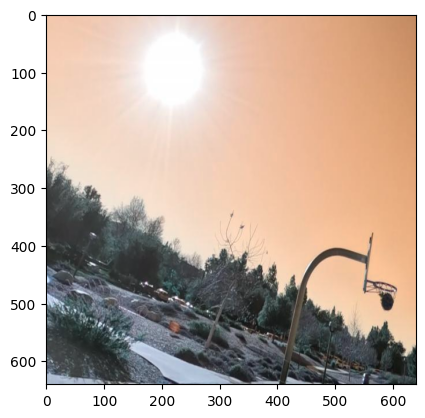

In [88]:
check_img = cv2.imread("/content/Basketball-goal-detection-10/test/images/GX010006-frame-at-11m22s_jpg.rf.19ba7e093807c769ccc5451031f820b0.jpg", cv2.IMREAD_ANYCOLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(check_img.shape)
plt.imshow(check_img)
plt.show()

In [89]:
images_dirs = get_train_test_valid_img_dirs(PROJECT_NAME)
for dir in images_dirs:
  if not os.path.isdir(dir):
    continue
  for filename in os.listdir(dir):
      hoop_detect_resize(dir, filename, PROJECT_NAME)

No detections for /content/basketball-74/test/images/ima-2-49_jpg.rf.e33200a2edb2ccdc5b7fc304ddd7516e.jpg
No detections for /content/basketball-74/test/images/im-11-30_jpg.rf.637c4e1f0347017fe1da8aeee7055d0c.jpg
No detections for /content/basketball-74/test/images/im-11-31_jpg.rf.8b6cd9c627bd6a96bbc6c5234c21f36c.jpg
No detections for /content/basketball-74/test/images/ima-1-26_jpg.rf.16f5408ec2d585dc8854d419310b1da6.jpg
No detections for /content/basketball-74/test/images/ima-1-28_jpg.rf.1fedc157d2a6e3a8e4312bc512b4871a.jpg
No detections for /content/basketball-74/test/images/ima-4-48_jpg.rf.9b02adcdbaa143ef60b77f92674349b9.jpg
No detections for /content/basketball-74/test/images/ima-2-55_jpg.rf.3c717118aff89402d30b9d50acea702c.jpg
No detections for /content/basketball-74/test/images/ima-1-23_jpg.rf.2563a07f9fd3a2f05e7a14ea9ceb9eac.jpg
No detections for /content/basketball-74/test/images/ima-4-46_jpg.rf.6657529ce63d979fae21db16ed156f3c.jpg
No detections for /content/basketball-74/test/

In [90]:
failed = [
"/content/basketball-74/test/images/ima-2-49_jpg.rf.e33200a2edb2ccdc5b7fc304ddd7516e.jpg",
"/content/basketball-74/test/images/im-11-30_jpg.rf.637c4e1f0347017fe1da8aeee7055d0c.jpg",
"/content/basketball-74/test/images/im-11-31_jpg.rf.8b6cd9c627bd6a96bbc6c5234c21f36c.jpg",
"/content/basketball-74/test/images/ima-1-26_jpg.rf.16f5408ec2d585dc8854d419310b1da6.jpg",
"/content/basketball-74/test/images/ima-1-28_jpg.rf.1fedc157d2a6e3a8e4312bc512b4871a.jpg",
"/content/basketball-74/test/images/ima-4-48_jpg.rf.9b02adcdbaa143ef60b77f92674349b9.jpg",
"/content/basketball-74/test/images/ima-2-55_jpg.rf.3c717118aff89402d30b9d50acea702c.jpg",
"/content/basketball-74/test/images/ima-1-23_jpg.rf.2563a07f9fd3a2f05e7a14ea9ceb9eac.jpg",
"/content/basketball-74/test/images/ima-4-46_jpg.rf.6657529ce63d979fae21db16ed156f3c.jpg",
"/content/basketball-74/test/images/ima-4-45_jpg.rf.60f0dba8bfbade3d246a1dbf1a0b6a7d.jpg",
"/content/basketball-74/test/images/im-10-47_jpg.rf.ba5e680a1a7afb9764f98983bf4d63b0.jpg",
"/content/basketball-74/test/images/ima-2-58_jpg.rf.010798fd01f0ad52566ca57f2c83a7f1.jpg",
"/content/basketball-74/test/images/im-2-31_jpg.rf.77256e4c9381aa1a23c1f3d7dd73bec1.jpg",
"/content/basketball-74/test/images/im-11-32_jpg.rf.91d2d3d98174804bbb6dfae2d2952a18.jpg",
"/content/basketball-74/test/images/ima-2-56_jpg.rf.63866eba66af904789bda4be65cb4c7c.jpg",
"/content/basketball-74/test/images/ima-4-47_jpg.rf.9d3858e956b0f3ba283193820f60806b.jpg",
"/content/basketball-74/test/images/im-11-29_jpg.rf.351b5484791c914573d0538078f2ff1d.jpg",
"/content/basketball-74/test/images/ima-4-42_jpg.rf.563b994957567c2720d0acf6cb5e5b8f.jpg",
"/content/basketball-74/test/images/im-7-8_jpg.rf.d9246febf869f85b92904d5a81b783db.jpg",
"/content/basketball-74/test/images/ima-4-41_jpg.rf.06af6a5ffcb7df0a937880a30d6514c4.jpg",
"/content/basketball-74/test/images/im-1-16_jpg.rf.a5f324be487f56477b9f0fa6e0a24a71.jpg",
"/content/basketball-74/test/images/ima-3-48_jpg.rf.73416a41dd62bd5dfcbdf277d580ac7e.jpg",
"/content/basketball-74/test/images/ima-2-50_jpg.rf.54d44495fac8013d06c2a6c5e84a9442.jpg",
"/content/basketball-74/train/images/left000180_png.rf.46179ecda126441cd89fd8264ebb84d4.jpg",
"/content/basketball-74/train/images/left000165_png.rf.f03a08581177b3e0da97b6003e76c2f4.jpg",
"/content/basketball-74/train/images/1645154877_3_jpg.rf.0c34af82d2c74c4051f7e382870fe56d.jpg",
"/content/basketball-74/train/images/20220124-4-4_jpg.rf.226c4249355105fcdcc4cc30cca52987.jpg",
"/content/basketball-74/train/images/left000177_png.rf.db03ee0a9030d17f4b8dbe29ad142892.jpg",
"/content/basketball-74/train/images/left000237_png.rf.8588f2124aa742a2d9d6de006976cc65.jpg",
"/content/basketball-74/train/images/1645154737_11_jpg.rf.1f0d679877651f6c3412a14c66dcb4a5.jpg",
"/content/basketball-74/train/images/1645154877_7_jpg.rf.6a8aa991cba0b5eeaa5fc4a16b015542.jpg",
"/content/basketball-74/train/images/1645166078_30_jpg.rf.ee9a34f2d7ab38b0a289320835c3a4cd.jpg",
"/content/basketball-74/train/images/WX20220411-150758_png.rf.6febbf5f06892e329bb776922c0959c4.jpg",
"/content/basketball-74/train/images/1645166233_18_jpg.rf.f0659290aeab3e690677e7fc2c211304.jpg",
"/content/basketball-74/train/images/1645166078_26_jpg.rf.dc6586c5c7c0ef29299c9329d755be29.jpg",
"/content/basketball-74/train/images/1645165628_25_jpg.rf.6c96baac26aa6fbc58a194bfadf6da64.jpg",
"/content/basketball-74/train/images/1645155839_5_jpg.rf.87bee5b839a7ecb62cfafe3e60ddd884.jpg",
"/content/basketball-74/train/images/20220124-8-1_jpg.rf.abaf1470eca23f5eb51eb9e19974c530.jpg",
"/content/basketball-74/train/images/left000164_png.rf.6bb25d9a2dbb6122f47c0c274a918a6d.jpg",
"/content/basketball-74/train/images/1645165412_24_jpg.rf.02c42a63765434b5a2bf1075844d92c2.jpg",
"/content/basketball-74/train/images/20220124-1-4_jpg.rf.47874ba4898aa6149c41142b45e25e31.jpg",
"/content/basketball-74/train/images/left000353_png.rf.c581000d2fd2a7f995944d4215263c44.jpg",
"/content/basketball-74/train/images/1645156545_4_jpg.rf.a3e8e1238ec63bec0f962478e13b9b15.jpg",
"/content/basketball-74/train/images/20211223-1-7_jpg.rf.ba5ff36fa8e741b4ce8912010fe3ca3c.jpg",
"/content/basketball-74/train/images/left000377_png.rf.bb0f90ba23800db41ff74d611d5e13f3.jpg",
"/content/basketball-74/train/images/1645165628_23_jpg.rf.7961aca2872dbf346acf616ca11a96f8.jpg",
"/content/basketball-74/train/images/20220124-2-21_jpg.rf.f39d74f2c97e80903d31172c982b704d.jpg",
"/content/basketball-74/train/images/20220124-8-7_jpg.rf.24202b217bf91397047a3a93950e1ceb.jpg",
"/content/basketball-74/train/images/20211223-1-9_jpg.rf.70f8074fc3e206615c1459e3f1d340af.jpg",
"/content/basketball-74/train/images/1645154877_1_jpg.rf.379e5b03c72a74b7d7ef53f8e6561121.jpg",
"/content/basketball-74/train/images/left000171_png.rf.d6ec7720374940b9411247b79ef09746.jpg",
"/content/basketball-74/train/images/20220124-7-5_jpg.rf.b812bc263710e7a60314f6478a822884.jpg",
"/content/basketball-74/train/images/1645165360_24_jpg.rf.6fce3a448af81b8da72a257e80b6249d.jpg",
"/content/basketball-74/train/images/1645165628_24_jpg.rf.0385b0e8f3a30268a9314fa7305ceef7.jpg",
"/content/basketball-74/train/images/1645165474_23_jpg.rf.fc4021ed0495dc948a042594c41956cb.jpg",
"/content/basketball-74/train/images/20220124-2-9_jpg.rf.fd9ed8fa7a9c5542c6c6029e28891beb.jpg",
"/content/basketball-74/train/images/1645165347_30_jpg.rf.28b7314c7d9b2f999638c422db0c9536.jpg",
"/content/basketball-74/train/images/left000151_png.rf.f8619fc13b92e7e49c6dc56f5d6ff11e.jpg",
"/content/basketball-74/train/images/20220124-4-5_jpg.rf.f2393bdb9fd3ad8c9b5078cfd2ef8591.jpg",
"/content/basketball-74/train/images/20220124-4-3_jpg.rf.57cdcb94ac606de4123dc9c9fe1996b5.jpg",
"/content/basketball-74/train/images/left000359_png.rf.813e4eaff23dae464edd15f5da469fb3.jpg",
"/content/basketball-74/train/images/1645154997_2_jpg.rf.19010bdb448749ac7b104d7028653e35.jpg",
"/content/basketball-74/train/images/20211223-1-8_jpg.rf.b9a1a05f54d6afef137d5a051b51b5b3.jpg",
"/content/basketball-74/train/images/left000003_png.rf.529bfc8b43a861cc812caf5d2fa0a934.jpg",
"/content/basketball-74/train/images/20211223-1-10_jpg.rf.3c7d46a576d6884f2336556f35842661.jpg",
"/content/basketball-74/train/images/1645155218_13_jpg.rf.0a278ea8f7e7de3be1437522dd2214a1.jpg",
"/content/basketball-74/train/images/1645166078_28_jpg.rf.94197d1b5a052db440ab5c9f4c6e9d0e.jpg",
"/content/basketball-74/train/images/left000004_png.rf.812f6b5ef92e08c91013e58490ce9b48.jpg",
"/content/basketball-74/train/images/left000179_png.rf.4f9207c3ad6d26dcd3e1bf0938944a26.jpg",
"/content/basketball-74/train/images/20220124-3-13_jpg.rf.5cfca04264685c07b4c674035b5109b4.jpg",
"/content/basketball-74/train/images/1645154997_4_jpg.rf.340d925800236e8e152a12258904e4c4.jpg",
"/content/basketball-74/train/images/20220124-4-1_jpg.rf.f5eaaa9829212a4f12f367f378964e66.jpg",
"/content/basketball-74/train/images/left000170_png.rf.528dfc62e7f3e81a75d7758a18e00c58.jpg",
"/content/basketball-74/train/images/20220124-ql-2_jpg.rf.9c288defd1ba4417fd0caa00cd7d9e4a.jpg",
"/content/basketball-74/train/images/1645166078_27_jpg.rf.d96dbd41ea5787d5baf5f89d38f6b5ef.jpg",
"/content/basketball-74/train/images/1645166078_24_jpg.rf.b3ec01391f1d79846eebf52c8b928ef6.jpg",
"/content/basketball-74/train/images/20211223-6-21_jpg.rf.9da91a864faa01db9f71657ebd3e3aa7.jpg",
"/content/basketball-74/train/images/IMG_20200110_163144_jpg.rf.8acb91dc7a636a1c6917b222c415a8b2.jpg",
"/content/basketball-74/train/images/left000137_png.rf.f622436ee4bc76e6f4a8c0162da8c609.jpg",
"/content/basketball-74/train/images/1645165347_26_jpg.rf.883a1e12240b40d69ac6bd4ad9fbbc1c.jpg",
"/content/basketball-74/train/images/1645155218_14_jpg.rf.a342913dd9279fdf59882c486d3c8625.jpg",
"/content/basketball-74/train/images/20211223-1-11_jpg.rf.51de05bd11d8c1d5452fca2f28c6332f.jpg",
"/content/basketball-74/train/images/20220124-8-2_jpg.rf.91d4347d1dd7d3249f3e4e5242e856d5.jpg",
"/content/basketball-74/train/images/1645165385_15_jpg.rf.14cf3c20f3bd73da46fd5d91278773b3.jpg",
"/content/basketball-74/train/images/20211223-1-12_jpg.rf.d2d28dfe500d882d8955f2b7f0e439ee.jpg",
"/content/basketball-74/train/images/1645155218_5_jpg.rf.b3277caa8ebe7eecc7e57a843a255ba8.jpg",
"/content/basketball-74/train/images/left000146_png.rf.cfb5ba4a7b147d67486e6beac327f10f.jpg",
"/content/basketball-74/train/images/bjxl-376_jpg.rf.7163d6edd5eb6f0c319f9f4c5adecab6.jpg",
"/content/basketball-74/train/images/left000150_png.rf.efb32dcc9dd0629374c304567ea63e2f.jpg",
"/content/basketball-74/train/images/left000152_png.rf.485817c06c729e873c75a6f307a56ca1.jpg",
"/content/basketball-74/train/images/20211223-1-14_jpg.rf.4d376c2e7e3961e61ed95532c73bab83.jpg",
"/content/basketball-74/train/images/1645156259_10_jpg.rf.fe2817b59a09404751570213fef15c6e.jpg",
"/content/basketball-74/train/images/1645155387_28_jpg.rf.97b6e30be83c3cff7a978f8949b83132.jpg",
"/content/basketball-74/train/images/1645165508_25_jpg.rf.f99943b690143afb9aa6739b93621c85.jpg",
"/content/basketball-74/train/images/1645154877_5_jpg.rf.853ef8d9cb41a7fe207aa69a49a44394.jpg",
"/content/basketball-74/train/images/left000174_png.rf.bb5da77e7a6140d2af65ab36c8b0cff3.jpg",
"/content/basketball-74/train/images/left000371_png.rf.4164b0eebf18d56c28f8a8b288ff761f.jpg",
"/content/basketball-74/train/images/20211223-1-12_jpg.rf.9d85408458d6de45c8bc53ae5abc4053.jpg",
"/content/basketball-74/train/images/1645155839_3_jpg.rf.fbc0bad6c908b0a7f993e549a579a0cd.jpg",
"/content/basketball-74/train/images/right000608_png.rf.6cb8b56bd005bb141f4839174ff1fac3.jpg",
"/content/basketball-74/train/images/20220124-7-1_jpg.rf.0eff3b252fb4f4751761f6634129a9ce.jpg",
"/content/basketball-74/train/images/1645166078_29_jpg.rf.430632bc0af2fb01d6c2cb4c2d51c481.jpg",
"/content/basketball-74/train/images/left000002_png.rf.1975fe2e9132436b3edc181ffe76d935.jpg",
"/content/basketball-74/train/images/left000154_png.rf.bde74270b97e0a13cb12adabb00ed693.jpg",
"/content/basketball-74/train/images/left000149_png.rf.554e4d37033ffd4d88721b34ce27625f.jpg",
"/content/basketball-74/train/images/1645154997_3_jpg.rf.ab903e8248f61088982b3b671e476fff.jpg",
"/content/basketball-74/train/images/left000255_png.rf.88732988dc38eb0f3756fb2ea7a2be28.jpg",
"/content/basketball-74/train/images/left000142_png.rf.084bf1a0c0ea098167d1f30dd613767d.jpg",
"/content/basketball-74/train/images/20211223-6-22_jpg.rf.ddc76fcb8d9e4a9993cf8e2a521c4773.jpg",
"/content/basketball-74/train/images/20220124-7-3_jpg.rf.36db2a64be13ddfcac397bde46a5dce0.jpg",
"/content/basketball-74/train/images/left000005_png.rf.9fe92e59b0b5efb1ebc8c0635da87c9b.jpg",
"/content/basketball-74/train/images/1645155839_4_jpg.rf.a61ff0ff2ac1ba5b63cb97c03095b258.jpg",
"/content/basketball-74/train/images/20220124-8-5_jpg.rf.adbed1990df42d725fe97ffdcb96dc3f.jpg",
"/content/basketball-74/train/images/left000153_png.rf.4aa2318097156cd932445e5abf4629d7.jpg",
"/content/basketball-74/train/images/20220124-8-3_jpg.rf.0e8be1bd757ed6d330ca3ac46a407dfe.jpg",
"/content/basketball-74/train/images/WX20220418-170900_png.rf.23f4ea87125794c39f90ae66cbf4b885.jpg",
"/content/basketball-74/train/images/right000607_png.rf.f0703fe71d96b8e8a2ac3ab24696c59c.jpg",
"/content/basketball-74/train/images/1645154997_7_jpg.rf.554eb3655399e250aca6cb15dc7f581d.jpg",
"/content/basketball-74/train/images/20220124-8-8_jpg.rf.fba08b0e8bf651345ecf3a77cd2b80fc.jpg",
"/content/basketball-74/train/images/20211223-1-13_jpg.rf.5af01db2135169b655f0bdfa4011eb2c.jpg",
"/content/basketball-74/train/images/left000009_png.rf.2ea5f4a77e33208d9b443bb5b191e189.jpg",
"/content/basketball-74/train/images/1645165385_16_jpg.rf.53eeac999f06965d15861b1d410b7ee7.jpg",
"/content/basketball-74/train/images/1645154877_4_jpg.rf.4be487aeb3afecd1b9d53ecae7c2abd2.jpg",
"/content/basketball-74/train/images/left000179_png.rf.ec71a181733f87611709258ba3f13406.jpg",
"/content/basketball-74/train/images/left000178_png.rf.5dcf02445105b4ad77b45a40ed14a3d7.jpg",
"/content/basketball-74/train/images/1645154997_1_jpg.rf.83d99c549f98c195f0548c9b54593250.jpg",
"/content/basketball-74/train/images/1645166233_19_jpg.rf.5304b8fa5c796e0610ce99399fd1c460.jpg",
"/content/basketball-74/train/images/20211223-4-14_jpg.rf.86b342ecaafd2e70cb6aa58b451aaab0.jpg",
"/content/basketball-74/valid/images/20220124-7-2_jpg.rf.f8a4820e305502cca1ccd471ed43cb94.jpg",
"/content/basketball-74/valid/images/1645154493_1_jpg.rf.51d2179c5e489cac588da264fef31139.jpg",
"/content/basketball-74/valid/images/left000147_png.rf.ef003dd7e0c05f62ee0e870a2e95a363.jpg",
"/content/basketball-74/valid/images/1645165347_27_jpg.rf.5bf8895402ffb552e764fe45919d0d6f.jpg",
"/content/basketball-74/valid/images/20211223-4-15_jpg.rf.5e312857c6939c77f9a21bfb98c19903.jpg",
"/content/basketball-74/valid/images/left000180_png.rf.465687380a7cdc547fda3a5dd5d913d9.jpg",
"/content/basketball-74/valid/images/left000146_png.rf.a3fa4d80aaa45536de6720929fdb5485.jpg",
"/content/basketball-74/valid/images/1645166078_25_jpg.rf.f6bfe1011a0f66c1afa2f4db7482e875.jpg",
"/content/basketball-74/valid/images/left000365_png.rf.9b389d6ff6fd92a4a32d9fe256f17623.jpg",
"/content/basketball-74/valid/images/left000006_png.rf.f2250c195b955c3bd95945836c05c7a4.jpg",
"/content/basketball-74/valid/images/left000126_png.rf.e5449c3b9d1cf6b184eda1a68afe4700.jpg",
"/content/basketball-74/valid/images/1645165885_24_jpg.rf.0225b3de0bbeefe6508f6665e96827ca.jpg",
"/content/basketball-74/valid/images/left000017_png.rf.562dd20a5c172e655581874006fc4dc3.jpg",
"/content/basketball-74/valid/images/20220124-2-1_jpg.rf.2b0ed279ace441bac655070d70f25e70.jpg",
"/content/basketball-74/valid/images/left000273_png.rf.d97b485a1cd2b7c71c5df632ed1604a9.jpg",
"/content/basketball-74/valid/images/1645154877_2_jpg.rf.a6e007fd7309241cca47a7045304d32f.jpg",
"/content/basketball-74/valid/images/WX20220418-171103_png.rf.b8c1638da433ab09969ed1a708cf2684.jpg",
"/content/basketball-74/valid/images/1645156259_11_jpg.rf.c5e75d2a55a972eddbb84d335647db7a.jpg",
"/content/basketball-74/valid/images/left000155_png.rf.876fb552f2257b8201302eb4d1c7ea00.jpg",
"/content/basketball-74/valid/images/1645154877_6_jpg.rf.ac570416f7c7592dcf26f4ad3d9ecfb7.jpg",
"/content/basketball-74/valid/images/WX20220428-172021_png.rf.1b15e295ca44f6116d309b7b1cb8947b.jpg",
"/content/basketball-74/valid/images/1645165347_29_jpg.rf.9c4b057603234651afcbf30bb2acf6af.jpg",
"/content/basketball-74/valid/images/1645154997_5_jpg.rf.76533c96fe8b988e3795ae0c9565b3a6.jpg",
"/content/basketball-74/valid/images/left000159_png.rf.2e6b59418001ded394ed0f28ceaf3433.jpg",
]

copy_to_failed(failed)

### 2142 images

https://universe.roboflow.com/project-c4ekm/qiji_sport

In [91]:
project = rf.workspace("project-c4ekm").project("qiji_sport")
version = project.version(13)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to qiji_sport-13 in yolov5pytorch:: 100%|██████████| 9163/9163 [00:04<00:00, 2245.54it/s]


In [92]:
PROJECT_NAME = "qiji_sport-13"

(640, 640, 3)


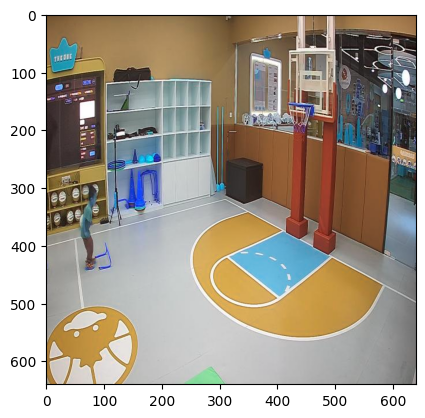

In [93]:
check_img = cv2.imread("/content/qiji_sport-13/test/images/frame_1019_002950_jpg.rf.014931ec47ae2ffaa42859b7ecc9eb30.jpg", cv2.IMREAD_ANYCOLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(check_img.shape)
plt.imshow(check_img)
plt.show()

In [94]:
images_dirs = get_train_test_valid_img_dirs(PROJECT_NAME)
image_names = get_image_names_with_class_annot([2, 4], PROJECT_NAME)

for dir in images_dirs:
  if not os.path.isdir(dir):
    continue
  for filename in os.listdir(dir):
      if not remove_file_extension(filename) in image_names:
        continue
      hoop_detect_resize(dir, filename, PROJECT_NAME)

No detections for /content/qiji_sport-13/train/images/frame_9862_000112_jpg.rf.ab6e985166477cbddbf1a515d82214a4.jpg
No detections for /content/qiji_sport-13/train/images/frame_6600_000045_jpg.rf.46d424f99de74d1fa2a595c83d23f142.jpg
No detections for /content/qiji_sport-13/train/images/frame_6600_000053_jpg.rf.e92c334a1787105a38af5198f6b28234.jpg
No detections for /content/qiji_sport-13/train/images/frame_9862_000114_jpg.rf.543f56a8167867cd6b20bf15829e508f.jpg
No detections for /content/qiji_sport-13/train/images/frame_6600_000049_jpg.rf.cea8141c203b9770361c92a8a9185bc1.jpg
No detections for /content/qiji_sport-13/train/images/frame_6600_000045_jpg.rf.975a9804dc079d77998618cc7659a6cf.jpg
No detections for /content/qiji_sport-13/train/images/frame_2016_000115_jpg.rf.22431018130885c4b550403994fd1efc.jpg
No detections for /content/qiji_sport-13/train/images/frame_6600_000049_jpg.rf.c1939df37c7294485cbf4dc292c6de38.jpg
No detections for /content/qiji_sport-13/train/images/frame_2016_000121_

In [95]:
failed = [
    "/content/qiji_sport-13/train/images/frame_9862_000112_jpg.rf.ab6e985166477cbddbf1a515d82214a4.jpg",
"/content/qiji_sport-13/train/images/frame_6600_000045_jpg.rf.46d424f99de74d1fa2a595c83d23f142.jpg",
"/content/qiji_sport-13/train/images/frame_6600_000053_jpg.rf.e92c334a1787105a38af5198f6b28234.jpg",
"/content/qiji_sport-13/train/images/frame_9862_000114_jpg.rf.543f56a8167867cd6b20bf15829e508f.jpg",
"/content/qiji_sport-13/train/images/frame_6600_000049_jpg.rf.cea8141c203b9770361c92a8a9185bc1.jpg",
"/content/qiji_sport-13/train/images/frame_6600_000045_jpg.rf.975a9804dc079d77998618cc7659a6cf.jpg",
"/content/qiji_sport-13/train/images/frame_2016_000115_jpg.rf.22431018130885c4b550403994fd1efc.jpg",
"/content/qiji_sport-13/train/images/frame_6600_000049_jpg.rf.c1939df37c7294485cbf4dc292c6de38.jpg",
"/content/qiji_sport-13/train/images/frame_2016_000121_jpg.rf.a94f89c75c5076369a71a9f9fa741b2a.jpg",
"/content/qiji_sport-13/train/images/frame_2016_000121_jpg.rf.e9487605e22a2426063ad5ae3db5b0f9.jpg",
"/content/qiji_sport-13/train/images/frame_9862_000113_jpg.rf.520e578a81c32d9ac7b968e91b2f01f6.jpg",
"/content/qiji_sport-13/train/images/frame_2016_000121_jpg.rf.cd29afdeadd7674ab0b8c4766188f76d.jpg",
"/content/qiji_sport-13/train/images/frame_9862_000112_jpg.rf.51631312f86605ce27cedece62497f17.jpg",
"/content/qiji_sport-13/train/images/frame_1864_081438_1_jpg.rf.619a7f257afa5c3492bdeab419b1591a.jpg",
"/content/qiji_sport-13/train/images/frame_2016_000115_jpg.rf.2c88052a847319d129aacf3947697681.jpg",
"/content/qiji_sport-13/train/images/frame_9862_000113_jpg.rf.c708b41ec4efab2345ce791bd6cca3c0.jpg",
"/content/qiji_sport-13/train/images/frame_9862_000112_jpg.rf.a11a18021c2dd8a713b704b7ee82408c.jpg",
"/content/qiji_sport-13/train/images/frame_9862_000114_jpg.rf.598dbd3666a54ec26a830749375087f7.jpg",
"/content/qiji_sport-13/train/images/frame_1864_081438_1_jpg.rf.de3846ac7307744abaf9bfca7c1b0503.jpg",
"/content/qiji_sport-13/train/images/frame_6600_000053_jpg.rf.59696920e68204292ab14fc1f3e4542f.jpg",
"/content/qiji_sport-13/valid/images/frame_9753_000091_jpg.rf.838c8a2040fe48530caf735c07d9c18b.jpg",
"/content/qiji_sport-13/valid/images/frame_4007_058734_2_jpg.rf.807a97dfda979c39de7b89fe1d9d3cba.jpg",
"/content/qiji_sport-13/valid/images/frame_9862_000117_jpg.rf.007982712ae5780e1bdde4395712b6c3.jpg",
"/content/qiji_sport-13/valid/images/frame_9862_000111_jpg.rf.e2654a9a510dbc522f924794214acc26.jpg",
"/content/qiji_sport-13/valid/images/frame_2762_004884__jpg.rf.71ed83dd068cb0e181e4c539df9b754d.jpg",
]
copy_to_failed(failed)

## ZIP

In [96]:
!zip -r cropped.zip $CROPPED_IMAGES_FOLDER

  adding: content/cropped/ (stored 0%)
  adding: content/cropped/basketball-74_WX20220411-151500_png.rf.7a601eeadb1df4773f764b32914c2c66.jpg (deflated 3%)
  adding: content/cropped/basketball-74_20220124-5-24_jpg.rf.98de1f19e1390e2b0bacbdbb88ffb89d.jpg (deflated 3%)
  adding: content/cropped/shootcounter-ai-1_IMG_7371-202-mp4-t-0-6_jpg.rf.81b91c9557d220bdbc29968f9e9151aa.jpg (deflated 3%)
  adding: content/cropped/shootcounter-ai-1_video-mp4-t-13_jpg.rf.5d9c5211307e6843399fc34771d66fce.jpg (deflated 4%)
  adding: content/cropped/shootcounter-ai-1_IMG_7506-mp4-t-12-2_jpg.rf.2d2bd5a2540b7524d6608d4c2b42dd0c.jpg (deflated 2%)
  adding: content/cropped/Basketball-fyp-4_CW_Shot_mp4-128_jpg.rf.bca578d11520b7bcca83808274fa0862.jpg (deflated 3%)
  adding: content/cropped/shootcounter-ai-1_IMG_7507-mp4-t-28_jpg.rf.5343a204d859dfadb3f532aa7c79f627.jpg (deflated 3%)
  adding: content/cropped/basketball-74_bjxl-3339_jpg.rf.3894f21659801e979ff9acfe3329211d.jpg (deflated 3%)
  adding: content/croppe

In [97]:
!zip -r failed.zip $FAILED_DETECTION_FOLDER

  adding: content/failed/ (stored 0%)
  adding: content/failed/ima-2-49_jpg.rf.e33200a2edb2ccdc5b7fc304ddd7516e.jpg (deflated 1%)
  adding: content/failed/left000180_png.rf.46179ecda126441cd89fd8264ebb84d4.jpg (deflated 0%)
  adding: content/failed/20220124-7-2_jpg.rf.f8a4820e305502cca1ccd471ed43cb94.jpg (deflated 0%)
  adding: content/failed/left000165_png.rf.f03a08581177b3e0da97b6003e76c2f4.jpg (deflated 0%)
  adding: content/failed/1645154877_3_jpg.rf.0c34af82d2c74c4051f7e382870fe56d.jpg (deflated 1%)
  adding: content/failed/im-11-30_jpg.rf.637c4e1f0347017fe1da8aeee7055d0c.jpg (deflated 1%)
  adding: content/failed/frame_9753_000091_jpg.rf.838c8a2040fe48530caf735c07d9c18b.jpg (deflated 1%)
  adding: content/failed/20220124-4-4_jpg.rf.226c4249355105fcdcc4cc30cca52987.jpg (deflated 0%)
  adding: content/failed/left000177_png.rf.db03ee0a9030d17f4b8dbe29ad142892.jpg (deflated 0%)
  adding: content/failed/frame_9862_000112_jpg.rf.ab6e985166477cbddbf1a515d82214a4.jpg (deflated 0%)
  addi